# RL Project

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from enum import IntEnum

## 1. Environment & MDP methods

In [100]:
class Action(IntEnum):
    STAY = 0
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4

class MDP:
    
    # How to use : (even though all our PI methods don't use step())
    #
    # Use mdp.call(state, action) to get info on the environment.
    # --> Do NOT use T & R matrices to get info on the environnement.
    # --> You CAN use mdp.utils methods, as long as it has a update_n_calls parameter.
    # Use mdp.step(action) to move the agent .
    # Use mdp.V to store & update state values.
    # Use mdp.n_calls to get the number of calls made to the environnement.
    # Use mdp.reset() when the episode has ended to start over.

    def __init__(self, N = 5, discount_factor = 0.97, reward_range = 0.1):
        self.N = N
        self.n_states = N * N
        self.discount_factor = discount_factor
        self.reward_range = reward_range
        self.reset()
        self.T = self.generate_transition_matrix(N)
        self.R = self.generate_rewards(self.N, self.reward_range)
        self.displayer = MDP_Displayer(self)
        self.utils = MDP_Utils(self)
    
    def generate_transition_matrix(self, N):
        transition_matrix = np.zeros((N * N, len(Action)), dtype=int)
        for s, state in enumerate(transition_matrix):
            state[Action.UP] = s - N if s >= N else s
            state[Action.DOWN] = s + N if s < N * N - N else s
            state[Action.LEFT] = s - 1 if s % N else s
            state[Action.RIGHT] = s + 1 if (s + 1) % N else s
            state[Action.STAY] = s
        return transition_matrix
    
    def generate_rewards(self, N, reward_range):
        rewards = np.random.uniform(-reward_range, reward_range, N * N)
        rewards[np.random.randint(0, N * N)] = 1
        return rewards
    
    def generate_state_values(self, N):
        return np.random.normal(size = N * N)
    
    def reset(self):
        self.n_calls = 0
        self.state = 0 # Paper does no mention what state to start on: 0 or random ?
#         self.R = self.generate_rewards(self.N, self.reward_range)
        self.V = self.generate_state_values(self.N)
    
    def step(self, action):
        self.state = self.T[self.state, action]
        return self.state, self.R[self.state]
    
    def call(self, state, action):
        self.n_calls += 1
        new_state = self.T[state, action]
        return new_state, self.R[new_state]
        
class MDP_Displayer:
    
    def __init__(self, mdp):
        self.mdp = mdp
        self.set_action_colors()
    
    def display_rewards(self, numerical = False, colorbar = True, ticks = False, title = "Rewards"):
        self.display_heatmap(self.mdp.R, numerical, colorbar, ticks, title)
    
    def display_state_values(self, numerical = False, colorbar = True, ticks = False, title = "State values"):
        self.display_heatmap(self.mdp.V, numerical, colorbar, ticks, title)
        
    def display_actions_based_on_rewards(self, ticks = False, title = "Best actions based on rewards"):
        self.display_actions(self.mdp.utils.get_best_actions_based_on_rewards(False), ticks, title)
    
    def display_actions_based_on_state_values(self, ticks = False, title = "Best actions based on state values"):
        self.display_actions(self.mdp.utils.get_best_actions_based_on_state_values(), ticks, title)
    
    def display_heatmap(self, array, numerical = False, colorbar = True, ticks = False, title = "Heatmap"):
        data = np.reshape(array, (self.mdp.N, self.mdp.N))
        if not ticks: self.remove_ticks()
        if numerical: self.add_numerical(data)
        plt.imshow(data)
        plt.title(title)
        if colorbar: plt.colorbar()
        plt.show()
        
    def display_actions(self, actions, ticks = False, title = "Actions"):  
        self.add_action_legend()
        data = np.reshape(actions, (self.mdp.N, self.mdp.N))
        if not ticks: self.remove_ticks()
        plt.imshow(data, cmap = self.action_cmap, norm = self.action_norm)
        plt.title(title)
        plt.show()
    
    def remove_ticks(self):
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        for tick in plt.gca().xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
        for tick in plt.gca().yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
    
    # Adds numerical data inside each cell of the plot
    def add_numerical(self, data):
        image = plt.imshow(data)
        threshold = image.norm(data.max()) * 2/3
        for i in range(len(data)):
            for j in range(len(data[i])):
                color = int(image.norm(data[i, j]) < threshold)
                text = plt.gca().text(j, i, round(data[i, j], 2),
                                      ha = "center", va = "center", color = str(color))
    
    def add_action_legend(self):
        handles = []
        for i, action in enumerate(Action):
            handles.append(mpatches.Patch(color = self.action_colors[i],
                                          label = str(action)[str(action).find(".") + 1:]))
        plt.legend(title="Actions", handles = handles, loc='upper left', bbox_to_anchor=(1, 1))
        
    def set_action_colors(self):
        self.action_colors = ["purple", "red", "blue", "green", "yellow"]
        self.action_cmap = mcolors.ListedColormap(self.action_colors)
        self.action_norm = mcolors.BoundaryNorm(list(range(len(Action) + 1)), self.action_cmap.N)
        
class MDP_Utils:
    
    def __init__(self, mdp):
        self.mdp = mdp
        
    # GENERATIVE METHODS ========================================================================
        
    # Warning: depth > 9 will most likely crash your kernel
    def get_action_trajecories(self, depth):
        return np.array(np.meshgrid(*[Action] * depth)).T.reshape(-1, depth)
    
    def get_uniform_policy(self):
        return np.ones((self.mdp.n_states, len(Action)), dtype=int) / len(Action)
    
    def get_greedy_policy(self):
        return self.actions_to_greedy_policy(self.get_best_actions_based_on_rewards())
        
    # INFORMATIVE METHODS =======================================================================
    
    def get_best_actions_based_on_rewards(self, update_n_calls = True):
        return np.argmax(self.get_action_rewards(update_n_calls), 1)
    
    def get_best_actions_based_on_state_values(self):
        return np.argmax(self.get_action_state_values(), 1)   
    
    # Return rewards array of size (n_state, actions)
    def get_action_rewards(self, update_n_calls = True):
        action_rewards = self.mdp.R[self.mdp.T]
        if update_n_calls: self.mdp.n_calls += self.mdp.n_states * len(Action)
        return action_rewards
    
    # Return state values array of size (n_state, actions), aka the value of the next state
    def get_action_state_values(self):
        action_state_values = self.mdp.V[self.mdp.T]
        return action_state_values
    
    # CONVERSION METHODS ========================================================================
        
    def actions_to_greedy_policy(self, best_actions):
        return np.eye(len(Action))[best_actions]
    
    def greedy_policy_to_actions(self, policy):
        return np.argmax(policy, 1)
    
    # top_left=(0,0) any_coord=(row, column)
    def state_to_coord(self, state):
        return (int(np.floor(state / self.mdp.N)), state % self.mdp.N)
    
    # top_left=(0,0) any_coord=(row, column)
    def coord_to_state(self, coord):
        return coord[0] * self.mdp.N + coord[1]
    
    # BELLMAN METHODS =====================================================================
    #
    # check out this link for a better explanation of R, P, V & T than the paper's
    # https://ai.stackexchange.com/questions/11057/what-is-the-bellman-operator-in-reinforcement-learning
    
    # Corresponds to bellman's P^π in the paper
    def get_bellman_transition_kernel(self, policy):
        P = np.zeros((self.mdp.n_states, self.mdp.n_states))
        for s, state_transition in enumerate(self.mdp.T):
            for action in Action:
                P[s, state_transition[action]] += policy[s, action] # Should we update n_calls?
        return P
    
    # Corresponds to bellman's r^π in the paper
    def get_bellman_rewards(self, policy, update_n_calls = True):
        if update_n_calls: self.mdp.n_calls += self.mdp.n_states * len(Action)
        return np.sum(self.mdp.R[self.mdp.T] * policy, 1)
    
    # Corresponds to T^π in the paper
    def bellman_operator(self, V, update_n_calls = True, policy = None):
        if policy is None: policy = self.get_uniform_policy()
        R = self.get_bellman_rewards(policy, update_n_calls)
        P = self.get_bellman_transition_kernel(policy)
        V = R + self.mdp.discount_factor * P.dot(V)
        return V

    def policy_evaluation(self, policy, update_n_calls = True):
        P = self.get_bellman_transition_kernel(policy)
        R = self.get_bellman_rewards(policy, update_n_calls)
        inv = np.linalg.inv(np.eye(*P.shape) - self.mdp.discount_factor * P)
        V = inv.dot(R)
        return V
    
    # Corresponds to T in the paper (equivalent of stackexchange's T* method linked above)
    def bellman_optimatlity_operator(self, V, update_n_calls = True):
        if update_n_calls: self.mdp.n_calls += self.mdp.n_states * len(Action)
        R = self.mdp.R[self.mdp.T]
        Pv = V[self.mdp.T]
        V = np.max(R + self.mdp.discount_factor * Pv, 1)
        return V

    # Corresponds to an a Modified Policy iteration step (MPI)
    def NC_bellman_m_operator(self, V, m, policy, update_n_calls = True):
        for i in range(m):
            V = self.bellman_operator(V, update_n_calls, policy=policy)
        return V

    def bellman_m_operator(self, V, m, h, policy, update_n_calls = True):
        for i in range(h - 1):
            V = self.bellman_optimatlity_operator(V, update_n_calls)
        self.NC_bellman_m_operator(V, m, policy, update_n_calls)
        return V
    
    def NC_bellman_λ_operator(self, V, λ, policy, update_n_calls = True):
        P = self.get_bellman_transition_kernel(policy)
        Tv = self.bellman_operator(V, update_n_calls, policy)
        inv = np.linalg.inv(np.eye(*P.shape)-self.mdp.discount_factor*λ*P)
        V = V + inv.dot(Tv - V)
        return V
    
    def bellman_λ_operator(self, V, λ, h, policy, update_n_calls = True):
        for i in range(h - 1):
            V = self.bellman_optimatlity_operator(V, update_n_calls)
        V = self.NC_bellman_λ_operator(V, λ, policy, update_n_calls)
        return V
    
    # Corresponds to G_h in the paper
    def get_h_greedy_policy(self, V, h = 1, update_n_calls = True):
        for i in range(h - 1):
            V = self.bellman_optimatlity_operator(V, update_n_calls)
        V = self.bellman_operator(V, update_n_calls)
        best_actions = np.argmax(V[self.mdp.T], 1)
        policy = self.actions_to_greedy_policy(best_actions)
        V = self.policy_evaluation(policy)
        return policy, V

    def get_NC_hm_greedy_policy(self, V, h = 1, m = 1, update_n_calls = True):
        policy, _ = self.get_h_greedy_policy(V, h, update_n_calls)
        V = self.NC_bellman_m_operator(V, m, policy, update_n_calls)
        return policy, V

    def get_hm_greedy_policy(self, V, h = 1, m = 1, update_n_calls = True):
        policy, _ = self.get_h_greedy_policy(V, h, update_n_calls)
        V = self.bellman_m_operator(V, m, h, policy, update_n_calls)
        return policy, V
    
    def get_NC_λ_greedy_policy(self, V, λ = 1, h = 1, update_n_calls = True):
        policy, _ = self.get_h_greedy_policy(V, h, update_n_calls)
        V = self.NC_bellman_λ_operator(V, λ, policy, update_n_calls)
        return policy, V
    
    def get_λ_greedy_policy(self, V, λ = 1, h = 1, update_n_calls = True):
        policy, _ = self.get_h_greedy_policy(V, h, update_n_calls)
        V = self.bellman_λ_operator(V, λ, h, policy, update_n_calls)
        return policy, V

## 2. Algorithms

In [101]:
TOLERANCE = 1e-7

def value_or_policy_iteration(mdp = MDP(), tolerance = TOLERANCE):
    pass

def h_PI(mdp, h = 1, tolerance = TOLERANCE):
    if mdp.discount_factor < 0 or mdp.discount_factor >= 1:
        raise ValueError("h_PI() will not converge unless discount_factor ∈ [0, 1[")
    Vs = [mdp.V]
    while True:
        policy, V = mdp.utils.get_h_greedy_policy(Vs[-1], h)
        Vs.append(V)
        if np.allclose(Vs[-1], Vs[-2], tolerance): break
    print(f'Reached convergence in {len(Vs)} iterations.')
    return policy, V

def NC_hm_PI(mdp, h = 1, m = 1, tolerance = TOLERANCE):
    Vs = [mdp.V]
    while True:
        policy, V = mdp.utils.get_hm_greedy_policy(Vs[-1], h , m)
        Vs.append(V)
        if np.allclose(Vs[-1], Vs[-2], tolerance): break
    print(f'Reached convergence in {len(Vs)} iterations.')
    return policy, V

def hm_PI(mdp, h = 1, m = 1, tolerance = TOLERANCE):
    Vs = [mdp.V]
    while True:
        policy, V = mdp.utils.get_hm_greedy_policy(Vs[-1], h , m)
        Vs.append(V)
        if np.allclose(Vs[-1], Vs[-2], tolerance): break
    print(f'Reached convergence in {len(Vs)} iterations.')
    return policy, V

def NC_hλ_PI(mdp, h = 1, λ = 1, tolerance = TOLERANCE):
    Vs = [mdp.V]
    while True:
        policy, V = mdp.utils.get_NC_λ_greedy_policy(Vs[-1], λ, h)
        Vs.append(V)
        if np.allclose(Vs[-1], Vs[-2], tolerance): break
    print(f'Reached convergence in {len(Vs)} iterations.')
    return policy, V

def hλ_PI(mdp, h = 1, λ = 1, tolerance = TOLERANCE):
    Vs = [mdp.V]
    while True:
        policy, V = mdp.utils.get_λ_greedy_policy(Vs[-1], λ, h)
        Vs.append(V)
        if np.allclose(Vs[-1], Vs[-2], tolerance): break
    print(f'Reached convergence in {len(Vs)} iterations.')
    return policy, V

## 3. Experiments

Reached convergence in 227 iterations.


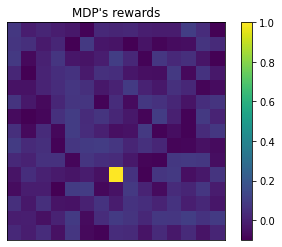

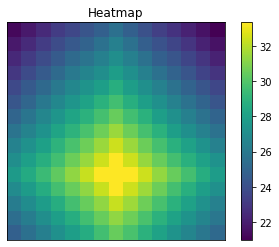

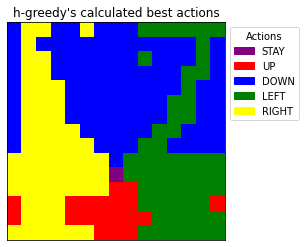

Number of calls to 'simulator': 2288250


In [102]:
# h_PI example
mdp = MDP(N = 15)
policy, V = hm_PI(mdp, h = 3, m = 3)
mdp.displayer.display_rewards(title = "MDP's rewards")
mdp.displayer.display_heatmap(V)
mdp.displayer.display_actions(mdp.utils.greedy_policy_to_actions(policy), title = "h-greedy's calculated best actions")
print(f"Number of calls to 'simulator': {mdp.n_calls}")

### 3.1 Use example of each algorithm

Reached convergence in 10 iterations.


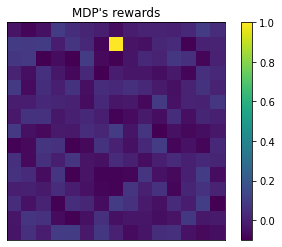

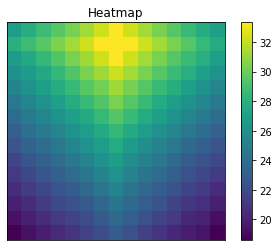

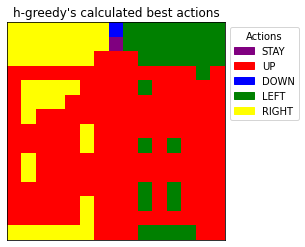

Number of calls to 'simulator': 30375


In [75]:
# h_PI example
mdp = MDP(N = 15)
policy, V = h_PI(mdp, h = 2)
mdp.displayer.display_rewards(title = "MDP's rewards")
mdp.displayer.display_heatmap(V)
mdp.displayer.display_actions(mdp.utils.greedy_policy_to_actions(policy), title = "h-greedy's calculated best actions")
print(f"Number of calls to 'simulator': {mdp.n_calls}")

Reached convergence in 35 iterations.


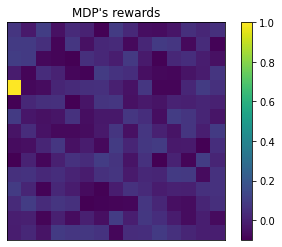

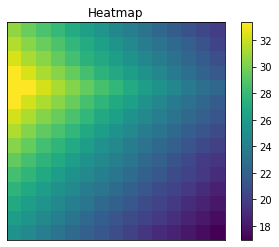

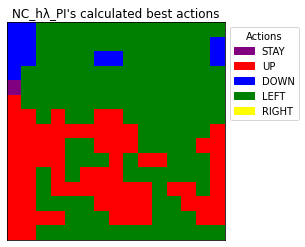

Number of calls to 'simulator': 459000


In [77]:
# NC_hλ_PI example
mdp.reset()
policy, V = NC_hλ_PI(mdp, h = 10, λ=0.95)
mdp.displayer.display_rewards(title = "MDP's rewards")
mdp.displayer.display_heatmap(V)
mdp.displayer.display_actions(mdp.utils.greedy_policy_to_actions(policy), title = "NC_hλ_PI's calculated best actions")
print(f"Number of calls to 'simulator': {mdp.n_calls}")

Reached convergence in 24 iterations.


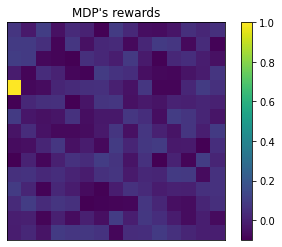

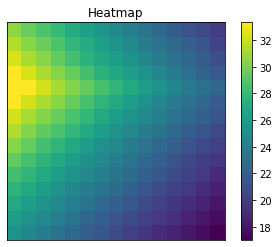

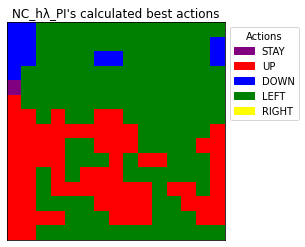

Number of calls to 'simulator': 543375


In [78]:
mdp.reset()
policy, V = hλ_PI(mdp, h = 10, λ=0.95)
mdp.displayer.display_rewards(title = "MDP's rewards")
mdp.displayer.display_heatmap(V)
mdp.displayer.display_actions(mdp.utils.greedy_policy_to_actions(policy), title = "NC_hλ_PI's calculated best actions")
print(f"Number of calls to 'simulator': {mdp.n_calls}")